In [20]:
import os
import re
from statistics import mode

from PIL import Image
import numpy as np
import pandas
import torch
from torchvision import transforms

In [21]:
def process_text(text):
    # lowercase
    text = text.lower()

    # 数詞を数字に変換
    num_word_to_digit = {
        'zero': '0', 'one': '1', 'two': '2', 'three': '3', 'four': '4',
        'five': '5', 'six': '6', 'seven': '7', 'eight': '8', 'nine': '9',
        'ten': '10'
    }
    for word, digit in num_word_to_digit.items():
        text = text.replace(word, digit)

    # 小数点のピリオドを削除
    text = re.sub(r'(?<!\d)\.(?!\d)', '', text)

    # 冠詞の削除
    text = re.sub(r'\b(a|an|the)\b', '', text)

    # 短縮形のカンマの追加
    contractions = {
        "dont": "don't", "isnt": "isn't", "arent": "aren't", "wont": "won't",
        "cant": "can't", "wouldnt": "wouldn't", "couldnt": "couldn't"
    }
    for contraction, correct in contractions.items():
        text = text.replace(contraction, correct)

    # 句読点をスペースに変換
    text = re.sub(r"[^\w\s':]", ' ', text)

    # 句読点をスペースに変換
    text = re.sub(r'\s+,', ',', text)

    # 連続するスペースを1つに変換
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [22]:
class VQADataset(torch.utils.data.Dataset):
    def __init__(self, df_path, image_dir, transform=None, answer=True):
        self.transform = transform  # 画像の前処理
        self.image_dir = image_dir  # 画像ファイルのディレクトリ
        self.df = pandas.read_json(df_path)  # 画像ファイルのパス，question, answerを持つDataFrame
        self.answer = answer

        # question / answerの辞書を作成
        self.question2idx = {}
        self.answer2idx = {}
        self.idx2question = {}
        self.idx2answer = {}

        # 質問文に含まれる単語を辞書に追加
        for question in self.df["question"]:
            question = process_text(question)
            words = question.split(" ")
            for word in words:
                if word not in self.question2idx:
                    self.question2idx[word] = len(self.question2idx)
        self.idx2question = {v: k for k, v in self.question2idx.items()}  # 逆変換用の辞書(question)

        if self.answer:
            # 回答に含まれる単語を辞書に追加
            for answers in self.df["answers"]:
                for answer in answers:
                    word = answer["answer"]
                    word = process_text(word)
                    if word not in self.answer2idx:
                        self.answer2idx[word] = len(self.answer2idx)
            self.idx2answer = {v: k for k, v in self.answer2idx.items()}  # 逆変換用の辞書(answer)

    def update_dict(self, dataset):
        """
        検証用データ，テストデータの辞書を訓練データの辞書に更新する．

        Parameters
        ----------
        dataset : Dataset
            訓練データのDataset
        """
        # self.question2idx = dataset.question2idx
        self.answer2idx = dataset.answer2idx
        # self.idx2question = dataset.idx2question
        self.idx2answer = dataset.idx2answer

    def __getitem__(self, idx):
        """
        対応するidxのデータ（画像，質問，回答）を取得．

        Parameters
        ----------
        idx : int
            取得するデータのインデックス

        Returns
        -------
        image : torch.Tensor  (C, H, W)
            画像データ
        question : torch.Tensor  (vocab_size)
            質問文をone-hot表現に変換したもの
        answers : torch.Tensor  (n_answer)
            10人の回答者の回答のid
        mode_answer_idx : torch.Tensor  (1)
            10人の回答者の回答の中で最頻値の回答のid
        """
        image = Image.open(f"{self.image_dir}/{self.df['image'][idx]}")
        image = self.transform(image)
        question = np.zeros(len(self.idx2question) + 1)  # 未知語用の要素を追加
        # question_words = self.df["question"][idx].split(" ")
        question_words = process_text(self.df["question"][idx]).split(" ") # 質問文の前処理
        for word in question_words:
            try:
                question[self.question2idx[word]] = 1  # one-hot表現に変換
            except KeyError:
                question[-1] = 1  # 未知語

        if self.answer:
            answers = [self.answer2idx[process_text(answer["answer"])] for answer in self.df["answers"][idx]]
            mode_answer_idx = mode(answers)  # 最頻値を取得（正解ラベル）

            return image, torch.Tensor(question), torch.Tensor(answers), int(mode_answer_idx)

        else:
            return image, torch.Tensor(question)

    def __len__(self):
        return len(self.df)

In [23]:
# dataloader / model
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# train_dataset = VQADataset(df_path="./data/train.json", image_dir="./data/train", transform=transform)
# test_dataset = VQADataset(df_path="./data/valid.json", image_dir="./data/valid", transform=transform, answer=False)
# test_dataset.update_dict(train_dataset)

In [24]:
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=os.cpu_count(), persistent_workers=(os.name == 'nt'), pin_memory=True)

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, persistent_workers=(os.name == 'nt'))
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, persistent_workers=(os.name == 'nt'))

In [25]:
# for image, question, answers, mode_answer in train_loader:
#     print(image.size(), question.size(), answers.size(), mode_answer.size())
#     break

In [26]:
# # dataの取り出し
# tmp = train_loader.__iter__()
# image, question, answers, mode_answer = tmp.next() 
# print(image.size(), question.size(), answers.size(), mode_answer.size())

In [27]:
df = pandas.read_json("./data/train.json")  # question, answerを持つDataFrame
df.head()

,image,question,answers
0,train_00000.jpg,What is this?,"[{'answer_confidence': 'yes', 'answer': 'beef ..."
1,train_00001.jpg,maybe it's because you're pushing it down instead,"[{'answer_confidence': 'yes', 'answer': 'unans..."
2,train_00002.jpg,What color is this item?,"[{'answer_confidence': 'yes', 'answer': 'grey'..."
3,train_00003.jpg,Can you tell me if this is like body wash or l...,"[{'answer_confidence': 'maybe', 'answer': 'lot..."
4,train_00004.jpg,Is it a paper?,"[{'answer_confidence': 'yes', 'answer': 'no'},..."


In [36]:
idx = 3

In [37]:
question = df['question'][idx]
print(question)

Can you tell me if this is like body wash or lotion or something like that?


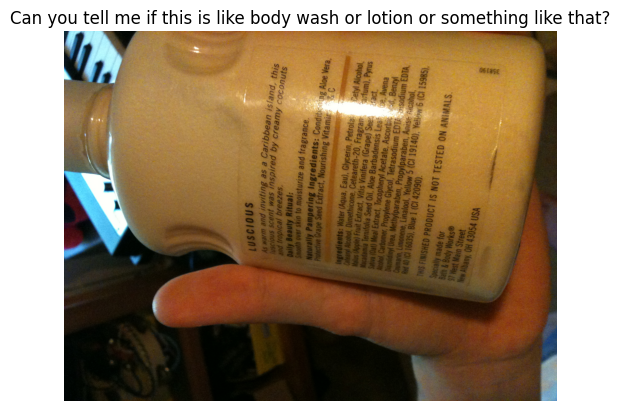

In [38]:
image_dir="./data/train"
image = Image.open(f"{image_dir}/{df['image'][idx]}")

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.imshow(image)
ax.axis('off')
ax.set_title(f'{question}')
plt.show()

In [39]:
from pprint import pprint

answers = df['answers'][idx]
pprint(answers)

[{'answer': 'lotion', 'answer_confidence': 'maybe'},
 {'answer': 'lotion', 'answer_confidence': 'maybe'},
 {'answer': 'unanswerable', 'answer_confidence': 'yes'},
 {'answer': 'yes', 'answer_confidence': 'yes'},
 {'answer': 'lotion', 'answer_confidence': 'yes'},
 {'answer': 'body wash', 'answer_confidence': 'yes'},
 {'answer': 'no', 'answer_confidence': 'yes'},
 {'answer': 'lotion', 'answer_confidence': 'maybe'},
 {'answer': 'lotion', 'answer_confidence': 'yes'},
 {'answer': 'lotion', 'answer_confidence': 'yes'}]


NVIDIA LAMB optimizerを使用する方法

- [NVIDIAでLAMBなどを使用する方法](https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587)
- [PythonのNVIDIA/apexがwindowsインストールできなかったのでメモ](https://note.com/kurogane_himaki/n/n5e8116954786)
- [【せっかち用】invalid command 'bdist_wheel' の対応方法](https://zenn.dev/ihcomirot/articles/2b054378779445)